### CSME2 Bonus Point Assignment II Part 3
<div style="text-align: right;font-size: 0.8em">Document Version 2.1.0, released 2022-02-09</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# FILL HERE` comments.
* Some cells create export file in the `output/` folder. _Include whole `output/` folder in your submission_.
* Make sure you restart the notebook's kernel and run everything in one go before submission
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting.

_v2.1.0 Fix imports and set default dtype to float_

In [1]:
import torch
import torch.optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as Func
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from tqdm.auto import tqdm
from pathlib import Path

ROOT = Path('.')
DATA = ROOT / 'data'
EXAMPLE_IMAGE = DATA / 'example_image.png'
OUTPUT = ROOT / 'output'

OUTPUT.mkdir(exist_ok=True)

# Enable reproducibility
torch.manual_seed(0)
torch.set_deterministic(True)
torch.set_default_dtype(torch.float32)

Class:  Good


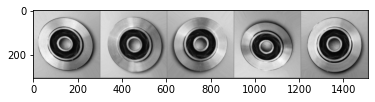

Class:  Defective


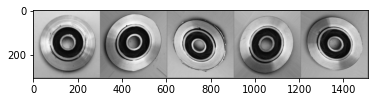

In [2]:
##### FILL HERE #####
#### Question 3.2 ###
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
batch_size = 32
classes = ('Defective','Good')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


CastDataset_train = ImageFolder("./data/train", transform = transform)
train_ds = DataLoader(CastDataset_train, batch_size=batch_size, shuffle=True,**kwargs)

CastDataset_test = ImageFolder("./data/test", transform = transform)
test_ds = DataLoader(CastDataset_test, batch_size=batch_size, shuffle=True,**kwargs)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
trainData = iter(train_ds)
Img,label = trainData.next()
val1 = np.zeros(5)
val0 = np.zeros(5)
count1 = 0
count0 = 0

for j in range(len(label)):
    if label[j] == 1 and count1 <5:
        val1[count1] = j
        count1 +=1
        
    elif label[j] == 0 and count0 < 5:
        val0[count0] = j
        count0 +=1
print("Class: ",classes[1])
imshow(torchvision.utils.make_grid(Img[val1]))

print("Class: ",classes[0])
imshow(torchvision.utils.make_grid(Img[val0]))

#####################

In [3]:
class SimpLeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ##### FILL HERE #####
        #### Question 3.3 ###
        self.conv1 = torch.nn.Conv2d(3,16,kernel_size = 3,padding=1,stride=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = torch.nn.Linear(16*150*150,16)
        self.fc2 = torch.nn.Linear(16,1)
        #####################
        
    def forward(self, x):
        ##### FILL HERE #####
        #### Question 3.3 ###
        x = self.pool(Func.relu(self.conv1(x)))
        x = torch.flatten(x,1)
        x = Func.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        #####################

_v2.1.0: fix typos, cast tensors to float and reshape outputs to labels_

_v2.1.1: add indication that labels should be transformed to either 0. or 1., so the loss function can understand them_

In [4]:
def train(net, batch_size, epochs, learning_rate, qname):
    n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f'Number of trainable parameters: {n_params}')
    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    losses = []
    min_valid_loss = np.inf
    ##### FILL HERE #####
    #### Question 3.4 ###
    # Create dataloader from train_ds
    dataloader = train_ds
    Val_dataloader = test_ds
    #####################
    
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:  # loop over the dataset multiple times
            running_loss = 0.0
            net.train()
            for i, (inputs, labels) in enumerate(dataloader):
#                 if torch.cuda.is_available():
#                     inputs,labels = inputs.to(dev),labels.to(dev)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                ##### FILL HERE #####
                #### Question 3.4 ###
                # Transform the class labels (in variable `labels`)
                # to be either 0. or 1, so the loss function
                # can understand them
                #####################
                
                # forward + backward + optimize
                outputs = net(inputs.to(torch.float32))
                outputs = outputs.reshape(labels.shape)
                loss = criterion(outputs, labels.to(torch.float32))
                loss.backward()
                optimizer.step()
                # training curve
                running_loss += loss.item() * inputs.shape[0]
            
            ##### FILL HERE #####
            #### Question 3.4 ###
            # Compute Validation loss
            val_loss = 0.0
            net.eval()
            with torch.no_grad():
                for j, (testing, testlabels) in enumerate(Val_dataloader):
                    test_op = net(testing.to(torch.float32))
                    test_op = test_op.reshape(testlabels.shape)
                    testlabels = testlabels.to(torch.float32)
                    
                    val_loss += criterion(test_op, testlabels).item() * testing.shape[0]
                
                if min_valid_loss > val_loss:
                    print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
                    min_valid_loss = val_loss
                    # Saving State Dict
                    torch.save(net.state_dict(), 'saved_model.pth')
            #####################
            
            losses.append([running_loss, val_loss])
            pbar.set_description(f"Loss {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

#     Save outputs
    with open(str(OUTPUT / f'{qname}.pt'), "wb") as f:
        torch.save(net, f)
    losses = np.array(losses)
    plt.plot(np.arange(len(losses)), losses[:, 0], label="train")
    plt.plot(np.arange(len(losses)), losses[:, 1], label="validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(OUTPUT / f'{qname}.png'))

SimpLeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=360000, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
Number of trainable parameters: 5760481


  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->155.035286) 	 Saving The Model
Validation Loss Decreased(155.035286--->130.388717) 	 Saving The Model
Validation Loss Decreased(130.388717--->129.435019) 	 Saving The Model
Validation Loss Decreased(129.435019--->86.261792) 	 Saving The Model
Validation Loss Decreased(86.261792--->76.504726) 	 Saving The Model
Validation Loss Decreased(76.504726--->65.573299) 	 Saving The Model
Validation Loss Decreased(65.573299--->50.177677) 	 Saving The Model
Validation Loss Decreased(50.177677--->44.376816) 	 Saving The Model


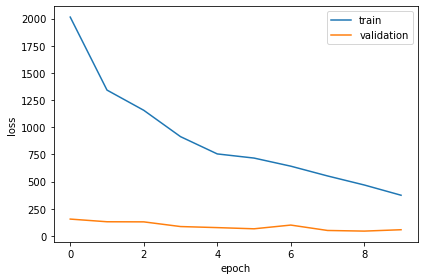

In [19]:
##### RUN HERE #####
#### Question 3.4 ###
net = SimpLeNet()

batch_size = 32
epochs = 10
learning_rate = 0.0001
qname = 'question_3-4'
print(net)
train(net, batch_size, epochs, learning_rate, qname)
#####################

In [46]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ##### FILL HERE #####
        #### Question 3.5 ###
        
        self.conv1 = torch.nn.Conv2d(3,5,kernel_size = 3,padding=1,stride=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)#150
        self.conv2 = torch.nn.Conv2d(5,16,kernel_size = 3,padding=1,stride=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=5,stride=5)#30
        
        self.fc1 = torch.nn.Linear(16*30*30,24)
        self.fc2 = torch.nn.Linear(24,1)
        #####################

    def forward(self, x):
        ##### FILL HERE #####
        #### Question 3.5 ###
        x = self.pool(Func.relu(self.conv1(x)))
        x = self.pool2(Func.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = Func.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        #####################

ConvNet(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=1, bias=True)
)
Number of trainable parameters: 346525


  0%|          | 0/10 [00:00<?, ?it/s]

Validation Loss Decreased(inf--->252.878843) 	 Saving The Model
Validation Loss Decreased(252.878843--->209.893660) 	 Saving The Model
Validation Loss Decreased(209.893660--->187.641504) 	 Saving The Model
Validation Loss Decreased(187.641504--->155.404630) 	 Saving The Model
Validation Loss Decreased(155.404630--->135.649346) 	 Saving The Model
Validation Loss Decreased(135.649346--->120.118411) 	 Saving The Model
Validation Loss Decreased(120.118411--->114.203718) 	 Saving The Model
Validation Loss Decreased(114.203718--->99.362480) 	 Saving The Model
Validation Loss Decreased(99.362480--->85.617340) 	 Saving The Model
Validation Loss Decreased(85.617340--->77.412943) 	 Saving The Model


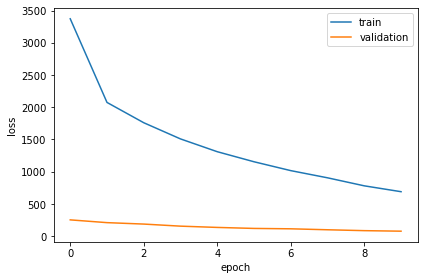

In [47]:
##### RUN HERE #####
#### Question 3.5 ###
convnet = ConvNet()
batch_size = 32
epochs = 10
learning_rate = 0.0001
qname = 'question_3-5'
print(convnet)
train(convnet, batch_size, epochs, learning_rate, qname)
#####################